In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
from scipy import signal
import scipy
import math
import multiprocessing
from tqdm.auto import tqdm

import rppglib

In [53]:
def _next_power_of_2(x):
    """Calculate the nearest power of 2."""
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def calculate_fft_hr_torch(ppg_signal, fs=30, low_pass=0.5, high_pass=3.5):
    """
    Taken from https://github.com/ubicomplab/rPPG-Toolbox/blob/main/evaluation/post_process.py
    Calculate heart rate based on PPG using Fast Fourier transform (FFT).
    """
    #ppg_signal = torch.from_numpy(ppg_signal.astype('float32'))[None, :]
    ppg_signal = ppg_signal[None, :]
    N = _next_power_of_2(ppg_signal.shape[1])

    pxx_ppg = torch.fft.rfft(ppg_signal, n=N, dim=1).abs()[0]
    #pxx_ppg = pxx_ppg**2
    
    f_ppg = torch.linspace(0.0, 15.0, pxx_ppg.shape[0])
    
    fmask_ppg = torch.argwhere((f_ppg >= low_pass) & (f_ppg <= high_pass))
    mask_ppg = torch.take(f_ppg, fmask_ppg)
    mask_pxx = torch.take(pxx_ppg, fmask_ppg)
    fft_hr = torch.take(mask_ppg, torch.argmax(mask_pxx, 0))[0] * 60    
    return fft_hr.item()

def filter_signal(signal, rate, freq, mode='high', order=4):
    hb_n_freq = freq / (rate / 2)
    b, a = scipy.signal.butter(order, hb_n_freq, mode)
    filtered = scipy.signal.filtfilt(b, a, signal)
    filtered = filtered.astype(signal.dtype)
    return filtered

def bandpass_filter(signal, rate, low_freq, high_freq, order=4):
    signal = filter_signal(signal, rate, high_freq, mode='low',  order=order)
    signal = filter_signal(signal, rate, low_freq,  mode='high', order=order)
    return signal


def preprocess(files):
    rgbs = list()
    ppgs = list()
    for file in tqdm(files):
        npz = np.load(file)
        video = npz['video']
        ppg = npz['ppg'] 
        rgb = video.mean(axis=(1, 2))
        
        ppg = bandpass_filter(ppg, 30, 0.5, 10)
        ppg -= ppg.mean()
        ppg /= ppg.std() + 1e-9
        rgbs.append(rgb)
        ppgs.append(ppg)
    rgbs = np.stack(rgbs).astype('float32')
    ppgs = np.stack(ppgs).astype('float32')
    return rgbs, ppgs

import cv2
def resize_video(video, height, width):
    resized_video = np.zeros((video.shape[0], height, width, 3), dtype=video.dtype)
    for i in range(video.shape[0]):
        resized_video[i] = cv2.resize(video[i], (width, height), interpolation=cv2.INTER_AREA)
    return resized_video

In [40]:
df = pd.read_csv('mcd_rppg.csv', index_col=0)

test_fold = 0
df = df[df['fold'] == test_fold]
#df = df[df['ppg_std'] != 0.0]
files = df['file'].to_list()
print(df.shape)

(240, 23)


In [41]:
videos = [torch.from_numpy(np.load(file)['video']).float() for file in tqdm(files)]

  0%|          | 0/240 [00:00<?, ?it/s]

In [43]:
ppgs_pt = list()
for file in tqdm(files):
    ppg = np.load(file)['ppg']
    ppg = bandpass_filter(ppg, 30, 0.5, 10)
    ppg -= ppg.mean()
    ppg /= ppg.std() + 1e-9
    ppg = torch.from_numpy(ppg)
    ppgs_pt.append(ppg)
ppgs_pt = torch.stack(ppgs_pt)

  0%|          | 0/240 [00:00<?, ?it/s]

In [133]:
import numba

@numba.njit(parallel=False) # on some processors this is faster #@numba.njit(parallel=True)
def extract_mean_frame(frame):
    H, W, Ch = frame.shape
    means = np.empty(Ch, dtype=np.float32)
    for ch in range(Ch):
        ch_sum = 0
        ch_count = 0
        for i in numba.prange(H):
            for j in numba.prange(W):
                val = frame[i, j, ch]
                #if val != 0:
                ch_sum += val
                ch_count += 1
        means[ch] = ch_sum / (ch_count + 1e-6)        
    return means

@numba.njit(parallel=True) # on some processors this is faster #@numba.njit(parallel=True)
def extract_mean_video(video):
    rgbs = np.empty((video.shape[0], 3), dtype=np.float32)
    for i in numba.prange(video.shape[0]):
        frame = video[i]
        rgb = extract_mean_frame(frame)
        rgbs[i, :] = rgb
    return rgbs


class POS(torch.nn.Module):
    def __init__(self, fs=30, window_sec=1.6, low_freq=0.75, high_freq=3.0):
        super().__init__()
        self.matrix = torch.nn.Parameter(data=torch.Tensor([[0, 1, -1], [-2, 1, 1]]).float(), requires_grad=False)
        self.window = math.ceil(window_sec * fs)
        self.fs = fs
        
        b, a = signal.butter(1, [low_freq / fs * 2, high_freq / fs * 2], btype='bandpass')
        self.a = torch.nn.Parameter(torch.Tensor(a), requires_grad=False)
        self.b = torch.nn.Parameter(torch.Tensor(b), requires_grad=False)

    def filter(self, ppg):
        ppg = torchaudio.functional.filtfilt(ppg, self.a, self.b)
        return ppg

    def window_function(self, rgb):
        Cn = self.normalize_rgb(rgb)
        S = torch.matmul(self.matrix, Cn)
        S_0 = S[:, :, 0, :]
        S_1 = S[:, :, 1, :]
    
        std_div = S_0.std(dim=2) / (S_1.std(dim=2) + 1e-4)
        std_div = std_div[:, :, None]
        h = S_0 + std_div * S_1
        return h

    def normalize_rgb(self, rgb):
        means = rgb.mean(dim=3)
        rgb = rgb / (means[:, :, :, None] + 1e-6)
        return rgb

    def forward(self, videos):
        rgb = self.process_videos(videos)
        batch_size, time, channel = rgb.shape
        unfolded = rgb.unfold(1, self.window, 1)
        hs = self.window_function(unfolded)
        total_length, batch_size = rgb.shape[1], rgb.shape[0]
        ppg = torch.zeros((batch_size, total_length), dtype=torch.float32).to(rgb.device)
        for i, end in enumerate(range(self.window, total_length)):
            start = end - self.window
            ppg[:, start:end] += hs[:, i] 
        ppg = self.filter(ppg)
        return ppg

    def process_videos(self, videos):
        result = list()
        for video in tqdm(videos):
            rgbs = extract_mean_video(video.numpy())
            rgbs = torch.from_numpy(rgbs)                    
            result.append(rgbs)
        result = torch.stack(result)
        return result

    


net = POS()
pred_ppg = net(videos)
aes = list()
for true, pred in zip(ppgs_pt, pred_ppg):
    true_hr = calculate_fft_hr_torch(true)
    pred_hr = calculate_fft_hr_torch(pred)
    aes.append(np.abs(true_hr - pred_hr))
print(np.mean(aes))
print()

  0%|          | 0/240 [00:00<?, ?it/s]

3.80859375



In [114]:
videos[0].shape

torch.Size([600, 101, 99, 3])

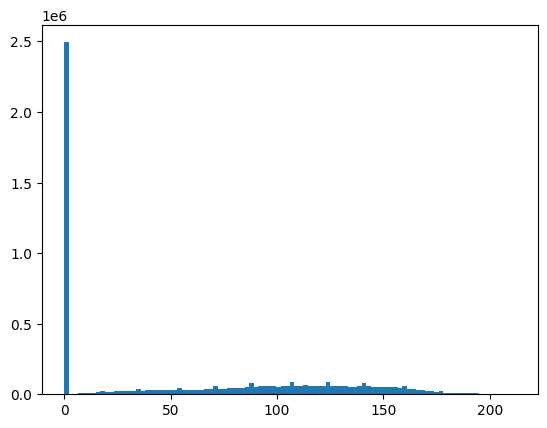

In [117]:
plt.hist(videos[0][:, :, :, 0].numpy().flatten(), bins=100)
plt.show()